In [1]:
# Modelado Avanzado Mejorado - Credit Scoring
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Preprocesamiento y Pipelines
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     TimeSeriesSplit, cross_val_score)
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest

# Modelos Avanzados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
try:
    from xgboost import XGBClassifier, XGBRegressor
    from lightgbm import LGBMClassifier, LGBMRegressor
    from catboost import CatBoostClassifier, CatBoostRegressor
    ADVANCED_LIBS_AVAILABLE = True
except ImportError:
    print("Advertencia: XGBoost, LightGBM o CatBoost no disponibles. Usando modelos base.")
    ADVANCED_LIBS_AVAILABLE = False


In [2]:
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Advertencia: Optuna no disponible. Usando RandomizedSearchCV.")
    from sklearn.model_selection import RandomizedSearchCV
    OPTUNA_AVAILABLE = False


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Métricas y Interpretabilidad
from sklearn.metrics import (classification_report, roc_auc_score, f1_score, 
                             precision_recall_curve, auc, r2_score, 
                             mean_squared_error, precision_score, average_precision_score)
import shap
from scipy.stats import ks_2samp
from scipy.stats.mstats import winsorize

In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
RANDOM_STATE = 42


In [5]:

class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformador que crea características temporales evitando data leakage.
    Solo usa información histórica previa al punto de predicción.
    """
    def __init__(self, lookback_months=3, target_month='sept'):
        self.lookback_months = lookback_months
        self.target_month = target_month
        self.month_order = ['april', 'may', 'june', 'july', 'aug', 'sept']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Obtener índice del mes objetivo
        target_idx = self.month_order.index(self.target_month)
        historical_months = self.month_order[:target_idx][-self.lookback_months:]
        
        # Solo usar meses históricos para evitar data leakage
        pay_cols = [f'pay_amt_{month}' for month in historical_months]
        bill_cols = [f'bill_amt_{month}' for month in historical_months]
        pay_status_cols = [f'pay_{month}' for month in historical_months]
        
        # Características de tendencia temporal
        if len(pay_cols) >= 2:
            X_transformed['payment_trend'] = self._calculate_trend(X_transformed, pay_cols)
            X_transformed['bill_trend'] = self._calculate_trend(X_transformed, bill_cols)
            X_transformed['payment_volatility'] = X_transformed[pay_cols].std(axis=1)
            
        # Características de comportamiento de pago
        X_transformed['avg_payment_delay'] = X_transformed[pay_status_cols].mean(axis=1)
        X_transformed['months_with_delay'] = (X_transformed[pay_status_cols] > 0).sum(axis=1)
        X_transformed['consecutive_delays'] = self._calculate_consecutive_delays(X_transformed, pay_status_cols)
        
        # Ratios financieros
        epsilon = 1e-6
        recent_bill = f'bill_amt_{historical_months[-1]}'
        recent_pay = f'pay_amt_{historical_months[-1]}'
        
        X_transformed['utilization_recent'] = X_transformed[recent_bill] / (X_transformed['limit_bal'] + epsilon)
        X_transformed['payment_ratio_recent'] = X_transformed[recent_pay] / (X_transformed[recent_bill] + epsilon)
        X_transformed['debt_to_limit_ratio'] = X_transformed[bill_cols].mean(axis=1) / (X_transformed['limit_bal'] + epsilon)
        
        return X_transformed
    
    def _calculate_trend(self, df, cols):
        """Calcula la tendencia temporal usando regresión lineal simple."""
        trends = []
        for idx, row in df.iterrows():
            y_vals = row[cols].values.astype(float)
            if len(y_vals) > 1:
                x_vals = np.arange(len(y_vals))
                slope, _ = np.polyfit(x_vals, y_vals, 1)
                trends.append(slope)
            else:
                trends.append(0)
        return pd.Series(trends, index=df.index)
    
    def _calculate_consecutive_delays(self, df, pay_status_cols):
        """Calcula el número máximo de retrasos consecutivos."""
        consecutive_delays = []
        for idx, row in df.iterrows():
            delays = (row[pay_status_cols] > 0).astype(int).values
            max_consecutive = 0
            current_consecutive = 0
            
            for delay in delays:
                if delay == 1:
                    current_consecutive += 1
                    max_consecutive = max(max_consecutive, current_consecutive)
                else:
                    current_consecutive = 0
            
            consecutive_delays.append(max_consecutive)
        
        return pd.Series(consecutive_delays, index=df.index)

In [6]:
class AdaptiveOutlierHandler(BaseEstimator, TransformerMixin):
    """
    Maneja outliers de forma adaptativa usando Isolation Forest
    en lugar de winsorización fija.
    """
    def __init__(self, contamination=0.05, random_state=42):
        self.contamination = contamination
        self.random_state = random_state
        self.outlier_detectors = {}
        
    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            if X[col].std() > 0:  # Solo para columnas con variabilidad
                detector = IsolationForest(
                    contamination=self.contamination,
                    random_state=self.random_state
                )
                detector.fit(X[[col]])
                self.outlier_detectors[col] = detector
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col, detector in self.outlier_detectors.items():
            outlier_mask = detector.predict(X_transformed[[col]]) == -1
            if outlier_mask.sum() > 0:
                # Reemplazar outliers con percentiles
                p99 = X_transformed[col].quantile(0.99)
                p01 = X_transformed[col].quantile(0.01)
                
                X_transformed.loc[outlier_mask & (X_transformed[col] > p99), col] = p99
                X_transformed.loc[outlier_mask & (X_transformed[col] < p01), col] = p01
        
        return X_transformed

In [7]:
class BusinessMetricsCalculator:
    """
    Calcula métricas orientadas al negocio bancario.
    """
    def __init__(self, cost_fp=100, benefit_tp=500, cost_fn=1000):
        self.cost_fp = cost_fp  # Costo de falso positivo (rechazar buen cliente)
        self.benefit_tp = benefit_tp  # Beneficio de verdadero positivo (identificar riesgo)
        self.cost_fn = cost_fn  # Costo de falso negativo (aprobar mal cliente)
    
    def calculate_profit_curve(self, y_true, y_pred_proba):
        """Calcula la curva de profit para diferentes thresholds."""
        thresholds = np.linspace(0.01, 0.99, 100)
        profits = []
        
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            profit = self._calculate_profit(y_true, y_pred)
            profits.append(profit)
        
        optimal_idx = np.argmax(profits)
        return thresholds, profits, thresholds[optimal_idx], profits[optimal_idx]
    
    def _calculate_profit(self, y_true, y_pred):
        """Calcula el profit total basado en la matriz de confusión."""
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        
        profit = (tp * self.benefit_tp) - (fp * self.cost_fp) - (fn * self.cost_fn)
        return profit
    
    def precision_at_k(self, y_true, y_pred_proba, k_values=[0.1, 0.2, 0.3]):
        """Calcula precision at k para diferentes percentiles de riesgo."""
        metrics = {}
        
        for k in k_values:
            threshold = np.percentile(y_pred_proba, (1-k)*100)
            high_risk_mask = y_pred_proba >= threshold
            
            if high_risk_mask.sum() > 0:
                precision_k = y_true[high_risk_mask].mean()
                metrics[f'precision_at_{k}'] = precision_k
            else:
                metrics[f'precision_at_{k}'] = 0
        
        return metrics

In [8]:
def create_ensemble_model():
    """Crea un modelo ensemble diversificado."""
    models = []
    
    if ADVANCED_LIBS_AVAILABLE:
        # Modelo basado en árboles con regularización
        lgbm = LGBMClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=RANDOM_STATE,
            verbose=-1
        )
        
        # Modelo con manejo automático de categóricas
        catboost = CatBoostClassifier(
            iterations=200,
            depth=6,
            learning_rate=0.1,
            l2_leaf_reg=3,
            random_state=RANDOM_STATE,
            verbose=False
        )
        
        models.extend([
            ('lgbm', lgbm),
            ('catboost', catboost)
        ])
    
    # Modelo lineal para diversidad
    log_reg = LogisticRegression(
        C=0.1,
        penalty='elasticnet',
        l1_ratio=0.5,
        solver='saga',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    
    # Random Forest con parámetros optimizados
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    models.extend([
        ('logistic', log_reg),
        ('random_forest', rf)
    ])
    
    return models

In [9]:
try:
    project_root = Path.cwd().parent
    processed_path = project_root / "data" / "processed"
    
    df_full = pd.read_csv(processed_path / "features_clasificacion.csv")
    df_reg = pd.read_csv(processed_path / "features_regresion.csv")
    
    print("Datasets cargados exitosamente.")
    print(f"Forma del dataset de clasificación: {df_full.shape}")
    print(f"Forma del dataset de regresión: {df_reg.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta: {e}")
    df_full = None
    df_reg = None

Datasets cargados exitosamente.
Forma del dataset de clasificación: (30000, 36)
Forma del dataset de regresión: (30000, 29)



MODELADO DE CLASIFICACIÓN AVANZADO
División temporal - Entrenamiento: 24000, Prueba: 6000

--- Entrenando Modelos del Ensemble ---

Entrenando lgbm...


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0100000000002183' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '363221.02000000066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '359638.13000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc0000

F1-Score CV: 0.4925 (+/- 0.0677)

Entrenando catboost...


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0100000000002183' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '363221.02000000066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '359638.13000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc0000

F1-Score CV: 0.5022 (+/- 0.0415)

Entrenando logistic...


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0100000000002183' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '363221.02000000066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '359638.13000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc0000

F1-Score CV: 0.3493 (+/- 0.0343)

Entrenando random_forest...


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0100000000002183' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '363221.02000000066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '359638.13000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc0000

F1-Score CV: 0.5133 (+/- 0.0577)

--- Evaluación y Selección del Mejor Modelo ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGBM:
  ROC-AUC: 0.7744
  Avg Precision: 0.5328
  Max Profit: $180,900
  Optimal Threshold: 0.069
  Precision@10%: 0.668

CATBOOST:
  ROC-AUC: 0.7759
  Avg Precision: 0.5342
  Max Profit: $172,600
  Optimal Threshold: 0.099
  Precision@10%: 0.670

LOGISTIC:
  ROC-AUC: 0.5992
  Avg Precision: 0.2995
  Max Profit: $159,600
  Optimal Threshold: 0.010
  Precision@10%: 0.413

RANDOM_FOREST:
  ROC-AUC: 0.7845
  Avg Precision: 0.5358
  Max Profit: $201,400
  Optimal Threshold: 0.109
  Precision@10%: 0.652

🏆 MEJOR MODELO: RANDOM_FOREST
Threshold óptimo: 0.109

--- Calibrando Probabilidades ---

--- EVALUACIÓN FINAL ---
              precision    recall  f1-score   support

  No Default       0.95      0.38      0.54      4734
     Default       0.29      0.93      0.44      1266

    accuracy                           0.50      6000
   macro avg       0.62      0.66      0.49      6000
weighted avg       0.81      0.50      0.52      6000


ROC-AUC Final (Calibrado): 0.7998


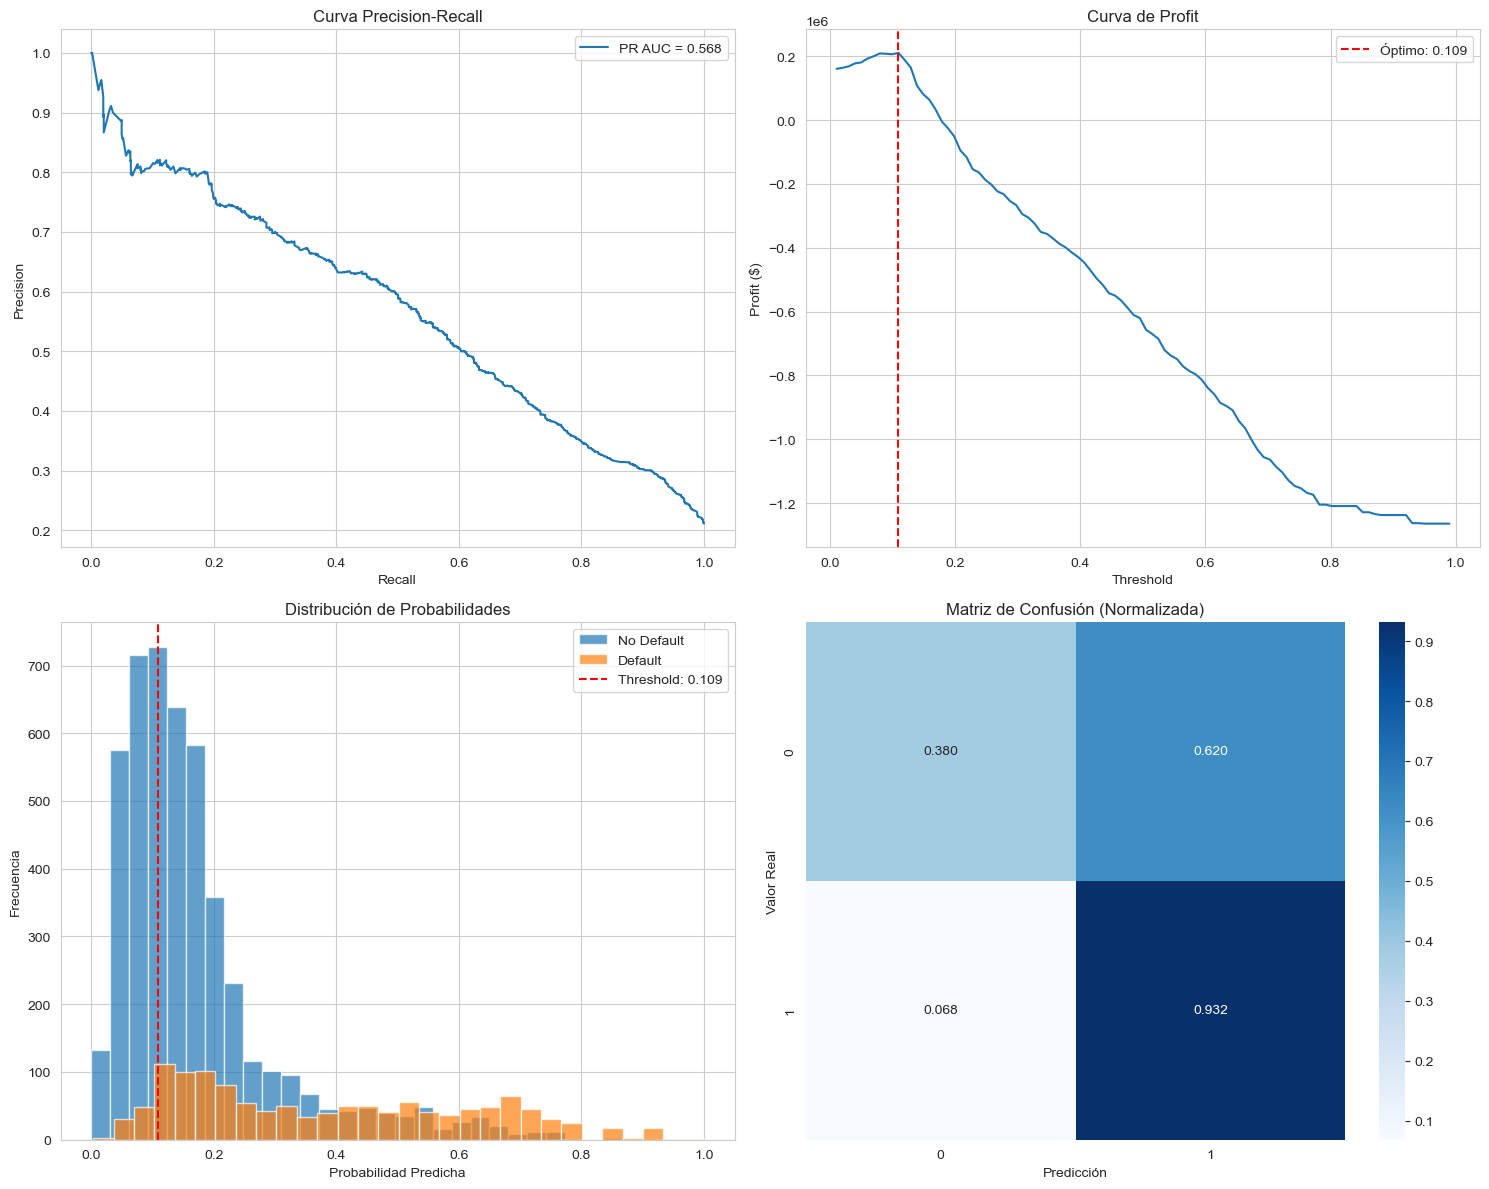


--- Análisis de Interpretabilidad ---


PermutationExplainer explainer: 201it [01:17,  2.44it/s]                         


Advertencia: No se pudieron obtener los nombres de las características del pipeline.
Se usarán nombres genéricos.

Importancia de Características (SHAP Summary Plot):


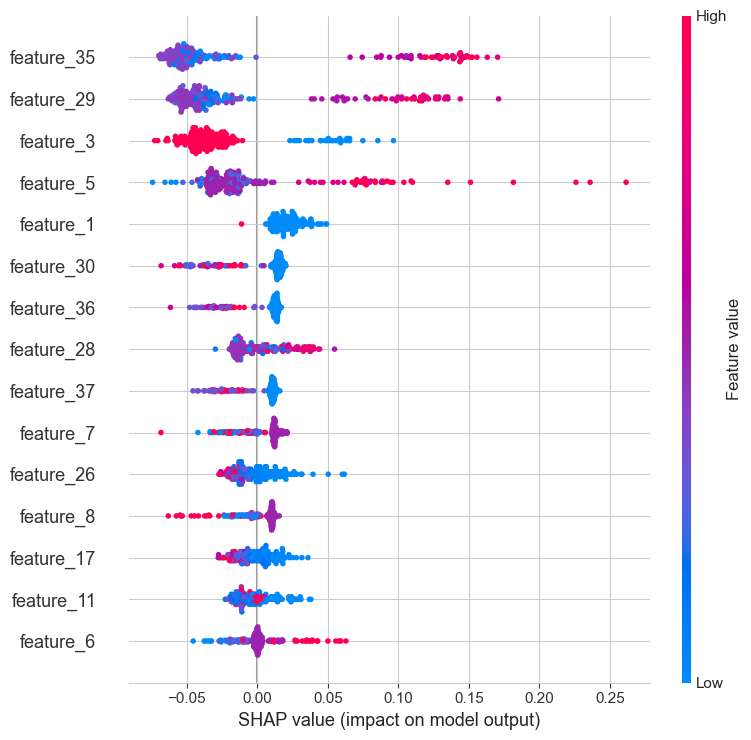


Gráfico de Dependencia (ej. para la característica más importante):


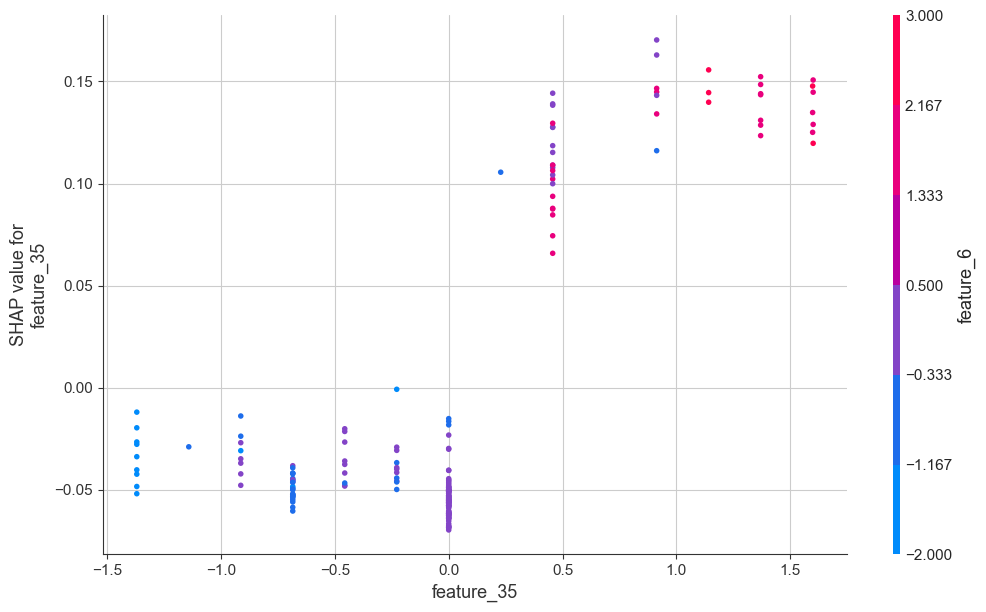

<Figure size 1200x700 with 0 Axes>

In [24]:

if df_full is not None:
    print("\n" + "="*70)
    print("MODELADO DE CLASIFICACIÓN AVANZADO")
    print("="*70)
    
    # Preparación de datos con validación temporal
    X = df_full.select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'])
    y = df_full['default_payment_next_month']
    
    # Simular orden temporal basado en ID (asumiendo orden cronológico)
    df_full_sorted = df_full.sort_values('ID').reset_index(drop=True)
    split_point = int(len(df_full_sorted) * 0.8)
    
    # División temporal: 80% entrenamiento, 20% prueba
    X_train = df_full_sorted.iloc[:split_point].select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'])
    X_test = df_full_sorted.iloc[split_point:].select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'])
    y_train = df_full_sorted.iloc[:split_point]['default_payment_next_month']
    y_test = df_full_sorted.iloc[split_point:]['default_payment_next_month']
    
    print(f"División temporal - Entrenamiento: {X_train.shape[0]}, Prueba: {X_test.shape[0]}")
    
    # Pipeline mejorado con transformadores custom
    feature_engineer = TemporalFeatureEngineer(lookback_months=3, target_month='sept')
    outlier_handler = AdaptiveOutlierHandler(contamination=0.05)
    
    # Crear ensemble diversificado
    ensemble_models = create_ensemble_model()
    best_models = {}
    
    print("\n--- Entrenando Modelos del Ensemble ---")
    
    for name, base_model in ensemble_models:
        print(f"\nEntrenando {name}...")
        
        # Pipeline completo para cada modelo
        pipeline = ImbPipeline([
            ('feature_engineer', feature_engineer),
            ('outlier_handler', outlier_handler),
            ('sampler', ADASYN(random_state=RANDOM_STATE)),  # ADASYN en lugar de SMOTE
            ('scaler', RobustScaler()),  # RobustScaler para mejor manejo de outliers
            ('classifier', base_model)
        ])
        
        # Entrenamiento con validación cruzada temporal
        test_size_int = int(len(X_train) * 0.15) 
        tscv = TimeSeriesSplit(n_splits=5, test_size=test_size_int)

        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, 
                                scoring='f1', n_jobs=-1)
        
        print(f"F1-Score CV: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Entrenamiento final
        pipeline.fit(X_train, y_train)
        best_models[name] = pipeline
    
    # Selección del mejor modelo basado en métricas de negocio
    print("\n--- Evaluación y Selección del Mejor Modelo ---")
    business_calc = BusinessMetricsCalculator()
    model_scores = {}
    
    for name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Métricas técnicas
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        # Métricas de negocio
        _, profits, optimal_threshold, max_profit = business_calc.calculate_profit_curve(y_test, y_pred_proba)
        precision_k = business_calc.precision_at_k(y_test, y_pred_proba)
        
        model_scores[name] = {
            'roc_auc': roc_auc,
            'avg_precision': avg_precision,
            'max_profit': max_profit,
            'optimal_threshold': optimal_threshold,
            **precision_k
        }
        
        print(f"\n{name.upper()}:")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  Avg Precision: {avg_precision:.4f}")
        print(f"  Max Profit: ${max_profit:,.0f}")
        print(f"  Optimal Threshold: {optimal_threshold:.3f}")
        print(f"  Precision@10%: {precision_k.get('precision_at_0.1', 0):.3f}")
    
    # Seleccionar mejor modelo basado en profit
    best_model_name = max(model_scores.keys(), 
                         key=lambda x: model_scores[x]['max_profit'])
    best_model = best_models[best_model_name]
    best_threshold = model_scores[best_model_name]['optimal_threshold']
    
    print(f"\n🏆 MEJOR MODELO: {best_model_name.upper()}")
    print(f"Threshold óptimo: {best_threshold:.3f}")
    
    # Calibración de probabilidades del mejor modelo
    print("\n--- Calibrando Probabilidades ---")
    
    # Extraer el clasificador del pipeline para calibración
    X_train_transformed = best_model[:-1].transform(X_train)
    base_classifier = best_model.named_steps['classifier']
    
    # Calibración con validación cruzada
    calibrated_clf = CalibratedClassifierCV(
        base_classifier, 
        method='isotonic', 
        cv=3
    )
    calibrated_clf.fit(X_train_transformed, y_train)
    
    # Predicciones finales calibradas
    X_test_transformed = best_model[:-1].transform(X_test)
    y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test_transformed)[:, 1]
    y_pred_final = (y_pred_proba_calibrated >= best_threshold).astype(int)
    
    # Evaluación final
    print("\n--- EVALUACIÓN FINAL ---")
    print(classification_report(y_test, y_pred_final, 
                              target_names=['No Default', 'Default']))
    
    final_roc_auc = roc_auc_score(y_test, y_pred_proba_calibrated)
    print(f"\nROC-AUC Final (Calibrado): {final_roc_auc:.4f}")
    
    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_calibrated)
    pr_auc = auc(recall, precision)
    
    axes[0,0].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    axes[0,0].set_xlabel('Recall')
    axes[0,0].set_ylabel('Precision')
    axes[0,0].set_title('Curva Precision-Recall')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # 2. Curva de Profit
    thresholds, profits, opt_thresh, max_profit = business_calc.calculate_profit_curve(
        y_test, y_pred_proba_calibrated)
    
    axes[0,1].plot(thresholds, profits)
    axes[0,1].axvline(opt_thresh, color='red', linestyle='--', 
                     label=f'Óptimo: {opt_thresh:.3f}')
    axes[0,1].set_xlabel('Threshold')
    axes[0,1].set_ylabel('Profit ($)')
    axes[0,1].set_title('Curva de Profit')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # 3. Distribución de Probabilidades
    axes[1,0].hist(y_pred_proba_calibrated[y_test == 0], alpha=0.7, 
                  label='No Default', bins=30)
    axes[1,0].hist(y_pred_proba_calibrated[y_test == 1], alpha=0.7, 
                  label='Default', bins=30)
    axes[1,0].axvline(best_threshold, color='red', linestyle='--', 
                     label=f'Threshold: {best_threshold:.3f}')
    axes[1,0].set_xlabel('Probabilidad Predicha')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].set_title('Distribución de Probabilidades')
    axes[1,0].legend()
    
    # 4. Matriz de Confusión Normalizada
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred_final, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', ax=axes[1,1])
    axes[1,1].set_title('Matriz de Confusión (Normalizada)')
    axes[1,1].set_ylabel('Valor Real')
    axes[1,1].set_xlabel('Predicción')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de Interpretabilidad con SHAP
    print("\n--- Análisis de Interpretabilidad ---")

    # Usar una muestra un poco más grande para el fondo del explainer si es posible
    X_train_sample = X_train_transformed[:500]
    X_test_for_shap = X_test_transformed[:200]  # Muestra para eficiencia en predicción

    try:
        # 1. Crear el Explainer de SHAP
        if 'tree' in str(type(base_classifier)).lower():
            explainer = shap.TreeExplainer(base_classifier)
        else:
            # Usamos un background dataset para aproximar las expectativas
            explainer = shap.Explainer(base_classifier.predict_proba, X_train_sample)
        
        # 2. Calcular los valores SHAP
        # Para modelos de probabilidad, accedemos a la salida de la clase positiva (Default)
        shap_values = explainer(X_test_for_shap)
        
        # Asegurarnos de que estamos usando los valores de la clase 'Default'
        # La nueva API de SHAP a menudo devuelve un objeto explainer con .values y .base_values
        if isinstance(shap_values, list): # Para la API antigua
            shap_values_positive = shap_values[1]
        else: # Para la nueva API
            shap_values_positive = shap_values.values[:,:,1]

        # Obtener nombres de características (con el fallback que ya tenías)
        try:
            feature_names = best_model[:-1].get_feature_names_out()
        except Exception:
            print("Advertencia: No se pudieron obtener los nombres de las características del pipeline.")
            print("Se usarán nombres genéricos.")
            feature_names = [f"feature_{i}" for i in range(X_test_for_shap.shape[1])]

        # Convertir los datos de prueba a un DataFrame con los nombres correctos
        X_test_shap_df = pd.DataFrame(X_test_for_shap, columns=feature_names)

        # 3. Gráfico de Importancia (Corregido)
        # Usamos el summary plot por defecto (tipo 'dot'), que es más robusto e informativo.
        print("\nImportancia de Características (SHAP Summary Plot):")
        shap.summary_plot(shap_values_positive, X_test_shap_df, max_display=15)

        # 4. Gráfico de Dependencia/Interacción (Corregido y Añadido)
        # Este gráfico muestra cómo una característica impacta la predicción
        # y cómo interactúa con otra característica (elegida automáticamente por SHAP).
        print("\nGráfico de Dependencia (ej. para la característica más importante):")
        
        # Obtener la característica más importante para mostrar un ejemplo
        most_important_feature = X_test_shap_df.columns[np.argsort(np.abs(shap_values_positive).mean(0))[-1]]
        
        fig, ax = plt.subplots() # Crear figura para tener más control
        shap.dependence_plot(most_important_feature, shap_values_positive, X_test_shap_df, ax=ax)
        plt.tight_layout()  # <-- CLAVE: Ajusta el gráfico para que no se corte
        plt.show()          # <-- CLAVE: Muestra el gráfico ajustado

    except Exception as e:
        print(f"Error en análisis SHAP: {e}")
        print("Continuando sin análisis de interpretabilidad...")


MODELADO DE REGRESIÓN AVANZADO (HURDLE MODEL)
Clientes que pagan en entrenamiento: 18800
Clientes que pagan en prueba: 4792

--- ETAPA 1: Modelo Hurdle (¿Pagará algo?) ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC Modelo Hurdle: 0.9835
Precisión Hurdle: 0.9543

--- ETAPA 2: Modelo de Monto ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '386343.64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '385480.50999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_82576/1379002631.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated 

RMSE CV: 9001.69 (+/- 1312.18)

--- EVALUACIÓN FINAL DEL MODELO HURDLE COMBINADO ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


R² Score (Todos): 0.6943
RMSE (Todos): 10209.93
MAE (Todos): 1968.31
MAPE (Todos): 6931.43%
R² Score (Solo pagadores): 0.6891
RMSE (Solo pagadores): 11406.95


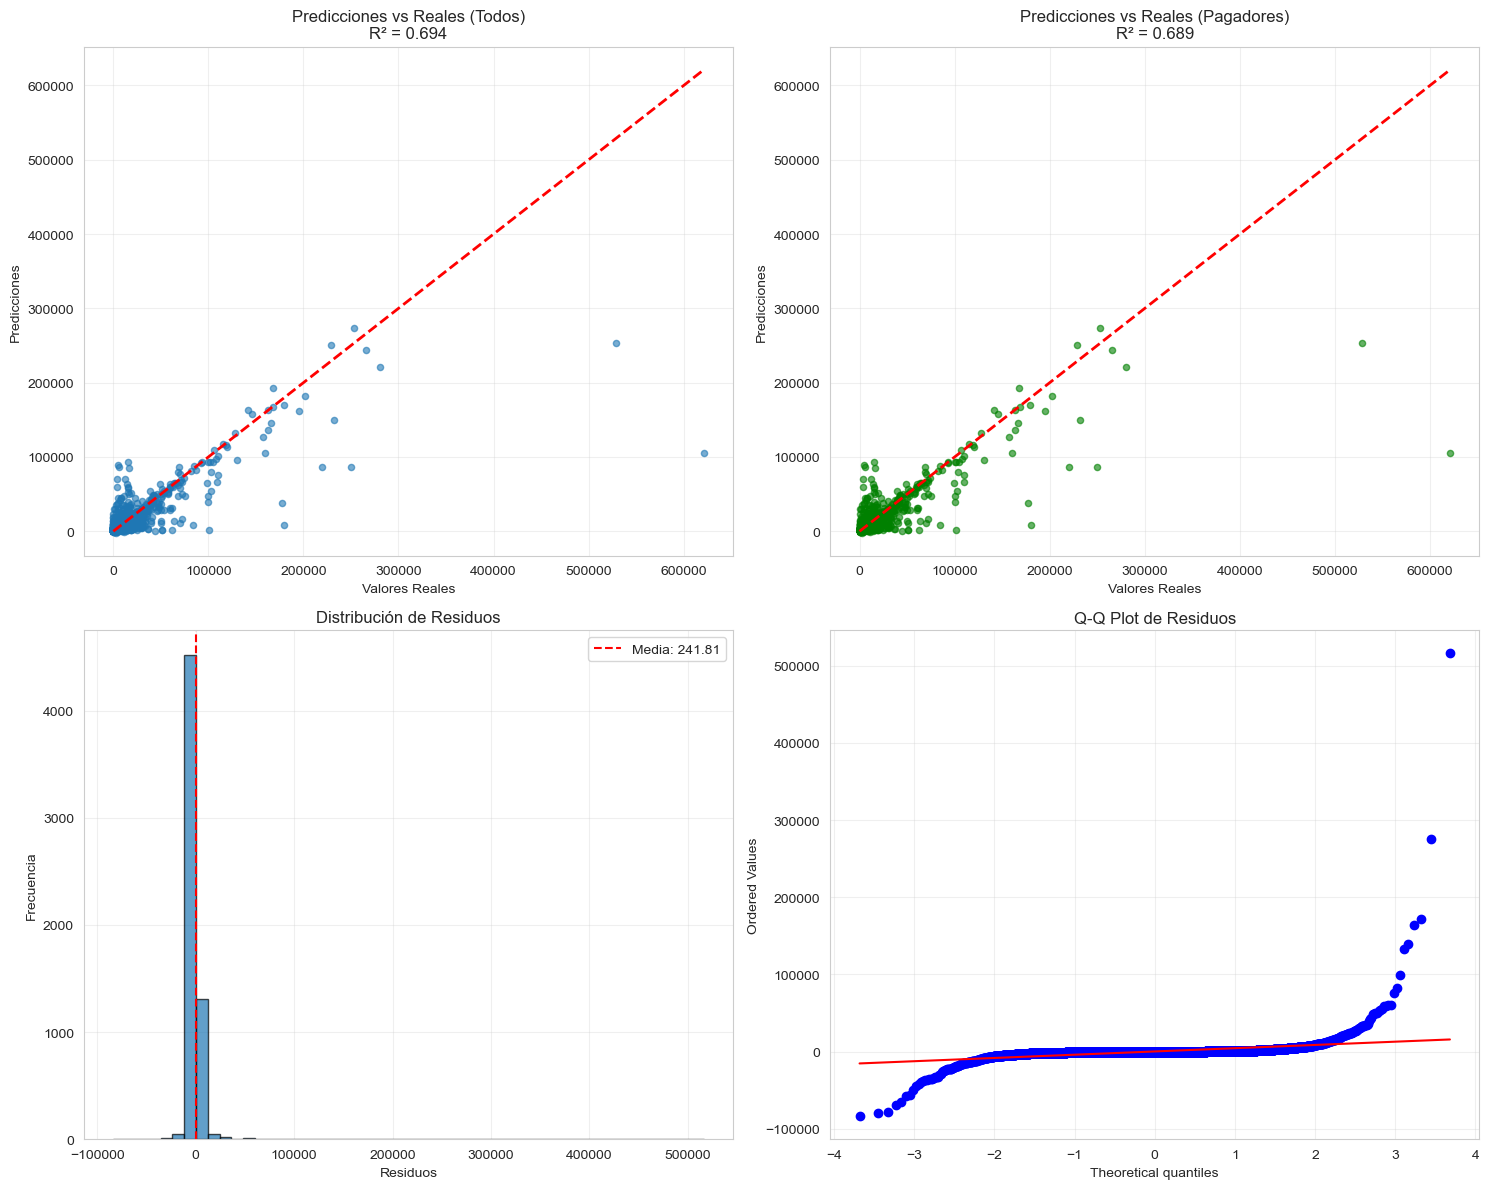


--- Análisis de Importancia de Características ---
Advertencia: No se pudieron obtener los nombres de las características del pipeline del hurdle.
Top 10 características más importantes para el modelo Hurdle:
       feature  importance              model
15  feature_15         452  Hurdle (¿Pagará?)
19  feature_19         339  Hurdle (¿Pagará?)
9    feature_9         293  Hurdle (¿Pagará?)
20  feature_20         264  Hurdle (¿Pagará?)
18  feature_18         258  Hurdle (¿Pagará?)
23  feature_23         238  Hurdle (¿Pagará?)
17  feature_17         221  Hurdle (¿Pagará?)
14  feature_14         218  Hurdle (¿Pagará?)
11  feature_11         208  Hurdle (¿Pagará?)
25  feature_25         189  Hurdle (¿Pagará?)


In [20]:
if df_reg is not None:
    print("\n" + "="*70)
    print("MODELADO DE REGRESIÓN AVANZADO (HURDLE MODEL)")
    print("="*70)
    
    # Preparación de datos
    X_reg = df_reg.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
    y_reg = df_reg['pay_amt_june']
    
    # Crear variable binaria para el hurdle (¿paga algo?)
    y_hurdle_binary = (y_reg > 0).astype(int)
    
    # División temporal
    df_reg_sorted = df_reg.sort_values('ID').reset_index(drop=True)
    split_point_reg = int(len(df_reg_sorted) * 0.8)
    
    X_train_reg = df_reg_sorted.iloc[:split_point_reg].select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
    X_test_reg = df_reg_sorted.iloc[split_point_reg:].select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
    y_train_reg = df_reg_sorted.iloc[:split_point_reg]['pay_amt_june']
    y_test_reg = df_reg_sorted.iloc[split_point_reg:]['pay_amt_june']
    y_train_binary = (y_train_reg > 0).astype(int)
    y_test_binary = (y_test_reg > 0).astype(int)
    
    # Datos solo para clientes que pagan (monto > 0)
    positive_mask_train = y_train_reg > 0
    positive_mask_test = y_test_reg > 0
    
    X_train_positive = X_train_reg[positive_mask_train]
    X_test_positive = X_test_reg[positive_mask_test]
    y_train_positive = y_train_reg[positive_mask_train]
    y_test_positive = y_test_reg[positive_mask_test]
    
    print(f"Clientes que pagan en entrenamiento: {positive_mask_train.sum()}")
    print(f"Clientes que pagan en prueba: {positive_mask_test.sum()}")
    
    # ETAPA 1: Modelo de Clasificación (Hurdle)
    print("\n--- ETAPA 1: Modelo Hurdle (¿Pagará algo?) ---")
    
    hurdle_pipeline = ImbPipeline([
        ('outlier_handler', AdaptiveOutlierHandler(contamination=0.03)),
        ('sampler', ADASYN(random_state=RANDOM_STATE)),
        ('scaler', RobustScaler()),
        ('classifier', LGBMClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            verbose=-1
        ) if ADVANCED_LIBS_AVAILABLE else RandomForestClassifier(
            n_estimators=150, 
            max_depth=10, 
            random_state=RANDOM_STATE, 
            n_jobs=-1
        ))
    ])
    
    # Entrenamiento del modelo hurdle
    hurdle_pipeline.fit(X_train_reg, y_train_binary)
    
    # Evaluación del hurdle
    y_pred_hurdle = hurdle_pipeline.predict(X_test_reg)
    y_pred_hurdle_proba = hurdle_pipeline.predict_proba(X_test_reg)[:, 1]
    
    hurdle_auc = roc_auc_score(y_test_binary, y_pred_hurdle_proba)
    print(f"ROC-AUC Modelo Hurdle: {hurdle_auc:.4f}")
    print(f"Precisión Hurdle: {(y_pred_hurdle == y_test_binary).mean():.4f}")
    
    # ETAPA 2: Modelo de Regresión (¿Cuánto pagará?)
    print("\n--- ETAPA 2: Modelo de Monto ---")
    
    # Pipeline para regresión con manejo mejorado de outliers
    regression_pipeline = Pipeline([
        ('outlier_handler', AdaptiveOutlierHandler(contamination=0.05)),
        ('scaler', RobustScaler()),
        ('transformer', PowerTransformer(method='yeo-johnson')),
        ('regressor', HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=8,
            learning_rate=0.1,
            l2_regularization=0.1,
            random_state=RANDOM_STATE
        ))
    ])
    
    # Entrenamiento con validación cruzada temporal
    test_size_reg_int = int(len(X_train_positive) * 0.2)
    tscv_reg = TimeSeriesSplit(n_splits=4, test_size=test_size_reg_int)

    rmse_scores = cross_val_score(
        regression_pipeline, 
        X_train_positive, 
        y_train_positive, 
        cv=tscv_reg, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    print(f"RMSE CV: {-rmse_scores.mean():.2f} (+/- {rmse_scores.std()*2:.2f})")
    
    # Entrenamiento final
    regression_pipeline.fit(X_train_positive, y_train_positive)
    
    # COMBINACIÓN FINAL DEL MODELO HURDLE
    print("\n--- EVALUACIÓN FINAL DEL MODELO HURDLE COMBINADO ---")
    
    # Predicciones de la etapa 1 (¿pagará?)
    will_pay_proba = hurdle_pipeline.predict_proba(X_test_reg)[:, 1]
    will_pay_pred = will_pay_proba > 0.5
    
    # Predicciones de la etapa 2 (¿cuánto?)
    amount_pred = regression_pipeline.predict(X_test_reg)
    
    # Combinación: monto predicho * probabilidad de pago
    final_predictions = amount_pred * will_pay_proba
    
    # Métricas de evaluación
    r2_hurdle = r2_score(y_test_reg, final_predictions)
    rmse_hurdle = np.sqrt(mean_squared_error(y_test_reg, final_predictions))
    mae_hurdle = np.mean(np.abs(y_test_reg - final_predictions))
    
    # Métricas adicionales para evaluación de negocio
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    
    mape_hurdle = mean_absolute_percentage_error(y_test_reg, final_predictions)
    
    # Evaluar solo en clientes que realmente pagan
    if positive_mask_test.sum() > 0:
        r2_positive_only = r2_score(y_test_positive, final_predictions[positive_mask_test])
        rmse_positive_only = np.sqrt(mean_squared_error(y_test_positive, final_predictions[positive_mask_test]))
    else:
        r2_positive_only = rmse_positive_only = 0
    
    print(f"R² Score (Todos): {r2_hurdle:.4f}")
    print(f"RMSE (Todos): {rmse_hurdle:.2f}")
    print(f"MAE (Todos): {mae_hurdle:.2f}")
    print(f"MAPE (Todos): {mape_hurdle:.2f}%")
    print(f"R² Score (Solo pagadores): {r2_positive_only:.4f}")
    print(f"RMSE (Solo pagadores): {rmse_positive_only:.2f}")
    
    # Visualizaciones del modelo de regresión
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predicciones vs Valores Reales (Todos)
    axes[0,0].scatter(y_test_reg, final_predictions, alpha=0.6, s=20)
    axes[0,0].plot([y_test_reg.min(), y_test_reg.max()], 
                   [y_test_reg.min(), y_test_reg.max()], '--r', linewidth=2)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales (Todos)\nR² = {r2_hurdle:.3f}')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Predicciones vs Valores Reales (Solo pagadores)
    if positive_mask_test.sum() > 0:
        axes[0,1].scatter(y_test_positive, final_predictions[positive_mask_test], 
                         alpha=0.6, s=20, color='green')
        axes[0,1].plot([y_test_positive.min(), y_test_positive.max()], 
                       [y_test_positive.min(), y_test_positive.max()], '--r', linewidth=2)
        axes[0,1].set_xlabel('Valores Reales')
        axes[0,1].set_ylabel('Predicciones')
        axes[0,1].set_title(f'Predicciones vs Reales (Pagadores)\nR² = {r2_positive_only:.3f}')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Distribución de Residuos
    residuals = y_test_reg - final_predictions
    axes[1,0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', 
                     label=f'Media: {residuals.mean():.2f}')
    axes[1,0].set_xlabel('Residuos')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].set_title('Distribución de Residuos')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Q-Q Plot de Residuos
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot de Residuos')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de Importancia de Características
    print("\n--- Análisis de Importancia de Características ---")
    
    # Importancia del modelo hurdle (clasificación)
    if hasattr(hurdle_pipeline.named_steps['classifier'], 'feature_importances_'):
        # Obtener datos transformados para obtener nombres correctos
        X_transformed_sample = hurdle_pipeline[:-1].transform(X_train_reg[:100])
        hurdle_importances = hurdle_pipeline.named_steps['classifier'].feature_importances_
        
        # Crear DataFrame de importancias del hurdle
        try:
            hurdle_feature_names = hurdle_pipeline[:-1].get_feature_names_out()
        except Exception:
            print("Advertencia: No se pudieron obtener los nombres de las características del pipeline del hurdle.")
            hurdle_feature_names = [f'feature_{i}' for i in range(len(hurdle_importances))]

        hurdle_importance_df = pd.DataFrame({
            'feature': hurdle_feature_names,
            'importance': hurdle_importances,
            'model': 'Hurdle (¿Pagará?)'
        }).sort_values('importance', ascending=False)

    print("Top 10 características más importantes para el modelo Hurdle:")
    print(hurdle_importance_df.head(10))
    
    # Importancia del modelo de regresión
    if hasattr(regression_pipeline.named_steps['regressor'], 'feature_importances_'):
        reg_importances = regression_pipeline.named_steps['regressor'].feature_importances_
        
        try:
            reg_feature_names = regression_pipeline[:-1].get_feature_names_out()
        except Exception:
            print("Advertencia: No se pudieron obtener los nombres de las características del pipeline de regresión.")
            reg_feature_names = [f'feature_{i}' for i in range(len(reg_importances))]
            
        reg_importance_df = pd.DataFrame({
            'feature': reg_feature_names,
            'importance': reg_importances,
            'model': 'Regresión (¿Cuánto?)'
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 características más importantes para el modelo de Regresión:")
        print(reg_importance_df.head(10))
        
        # Visualización comparativa de importancias
        if 'hurdle_importance_df' in locals():
            plt.figure(figsize=(15, 8))
            
            # Subplot para modelo hurdle
            plt.subplot(1, 2, 1)
            top_hurdle = hurdle_importance_df.head(15)
            plt.barh(range(len(top_hurdle)), top_hurdle['importance'])
            plt.yticks(range(len(top_hurdle)), top_hurdle['feature'])
            plt.xlabel('Importancia')
            plt.title('Importancia - Modelo Hurdle')
            plt.gca().invert_yaxis()
            
            # Subplot para modelo de regresión
            plt.subplot(1, 2, 2)
            top_reg = reg_importance_df.head(15)
            plt.barh(range(len(top_reg)), top_reg['importance'])
            plt.yticks(range(len(top_reg)), top_reg['feature'])
            plt.xlabel('Importancia')
            plt.title('Importancia - Modelo Regresión')
            plt.gca().invert_yaxis()
            
            plt.tight_layout()
            plt.show()


In [21]:
def analyze_population_stability(X_train, X_test, feature_cols=None, n_bins=10):
    """
    Calcula el Population Stability Index (PSI) para detectar drift.
    """
    if feature_cols is None:
        feature_cols = X_train.select_dtypes(include=[np.number]).columns
    
    psi_results = {}
    
    for col in feature_cols:
        if col in X_train.columns and col in X_test.columns:
            # Crear bins basados en los datos de entrenamiento
            _, bin_edges = np.histogram(X_train[col], bins=n_bins)
            
            # Calcular distribuciones
            train_dist, _ = np.histogram(X_train[col], bins=bin_edges, density=True)
            test_dist, _ = np.histogram(X_test[col], bins=bin_edges, density=True)
            
            # Normalizar para obtener proporciones
            train_prop = train_dist / train_dist.sum()
            test_prop = test_dist / test_dist.sum()
            
            # Evitar log(0) añadiendo pequeño epsilon
            epsilon = 1e-10
            train_prop = np.maximum(train_prop, epsilon)
            test_prop = np.maximum(test_prop, epsilon)
            
            # Calcular PSI
            psi = np.sum((test_prop - train_prop) * np.log(test_prop / train_prop))
            psi_results[col] = psi
    
    return psi_results


ANÁLISIS DE ESTABILIDAD POBLACIONAL
Population Stability Index (PSI) por característica:
PSI < 0.1: Estable | 0.1-0.2: Moderado | >0.2: Inestable
------------------------------------------------------------
sex                  |  0.062 | Estable
age                  |  0.014 | Estable
pay_sept             |  0.012 | Estable
limit_bal            |  0.008 | Estable
bill_amt_sept        |  0.007 | Estable
pay_amt_sept         |  0.007 | Estable
education            |  0.006 | Estable
marriage             |  0.002 | Estable


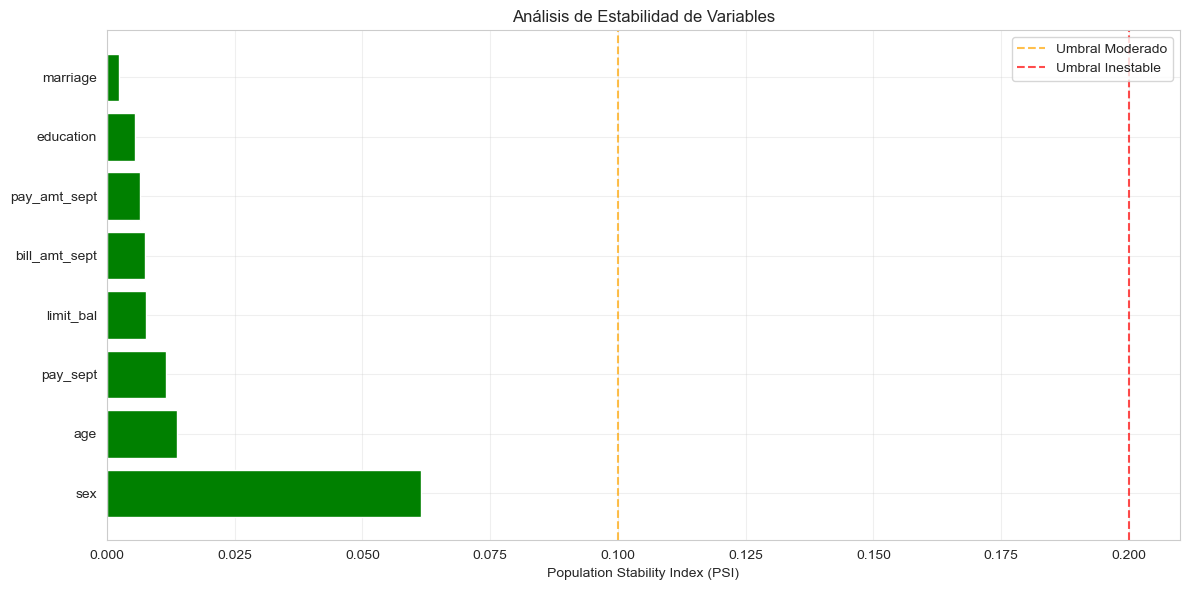

In [22]:
if df_full is not None and 'X_train' in locals():
    print("\n" + "="*70)
    print("ANÁLISIS DE ESTABILIDAD POBLACIONAL")
    print("="*70)
    
    # Seleccionar características originales para análisis de estabilidad
    original_features = ['limit_bal', 'age', 'bill_amt_sept', 'pay_amt_sept', 
                        'pay_sept', 'sex', 'education', 'marriage']
    available_features = [col for col in original_features if col in X_train.columns and col in X_test.columns]
    
    if available_features:
        psi_scores = analyze_population_stability(X_train, X_test, available_features)
        
        # Crear DataFrame de resultados PSI
        psi_df = pd.DataFrame([
            {'feature': k, 'psi': v, 'stability': 
             'Estable' if v < 0.1 else 'Moderado' if v < 0.2 else 'Inestable'} 
            for k, v in psi_scores.items()
        ]).sort_values('psi', ascending=False)
        
        print("Population Stability Index (PSI) por característica:")
        print("PSI < 0.1: Estable | 0.1-0.2: Moderado | >0.2: Inestable")
        print("-" * 60)
        for _, row in psi_df.iterrows():
            print(f"{row['feature']:20} | {row['psi']:6.3f} | {row['stability']}")
        
        # Visualización de estabilidad
        plt.figure(figsize=(12, 6))
        colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' 
                 for x in psi_df['psi']]
        
        plt.barh(range(len(psi_df)), psi_df['psi'], color=colors)
        plt.yticks(range(len(psi_df)), psi_df['feature'])
        plt.xlabel('Population Stability Index (PSI)')
        plt.title('Análisis de Estabilidad de Variables')
        plt.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Umbral Moderado')
        plt.axvline(x=0.2, color='red', linestyle='--', alpha=0.7, label='Umbral Inestable')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Recomendaciones basadas en PSI
        unstable_features = psi_df[psi_df['psi'] > 0.2]['feature'].tolist()
        if unstable_features:
            print(f"\n⚠️  ALERTA: Las siguientes variables muestran drift significativo:")
            for feature in unstable_features:
                print(f"   - {feature}")
            print("\nRecomendaciones:")
            print("1. Reentrenar el modelo con datos más recientes")
            print("2. Considerar recalibración de probabilidades")
            print("3. Implementar monitoreo continuo de estas variables")

In [23]:

print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)

if 'best_model_name' in locals():
    print(f"\n🎯 MODELO DE CLASIFICACIÓN SELECCIONADO: {best_model_name.upper()}")
    print(f"   • ROC-AUC: {model_scores[best_model_name]['roc_auc']:.3f}")
    print(f"   • Precision@10%: {model_scores[best_model_name].get('precision_at_0.1', 0):.3f}")
    print(f"   • Profit Máximo: ${model_scores[best_model_name]['max_profit']:,.0f}")
    print(f"   • Threshold Óptimo: {best_threshold:.3f}")

if 'r2_hurdle' in locals():
    print(f"\n📈 MODELO DE REGRESIÓN HURDLE:")
    print(f"   • R² Score: {r2_hurdle:.3f}")
    print(f"   • RMSE: ${rmse_hurdle:,.0f}")
    print(f"   • MAPE: {mape_hurdle:.1f}%")
    print(f"   • ROC-AUC Hurdle: {hurdle_auc:.3f}")

print(f"\n📊 MEJORAS IMPLEMENTADAS:")
print("   ✅ Validación temporal para evitar data leakage")
print("   ✅ Ingeniería de características sin información futura")
print("   ✅ Manejo adaptativo de outliers con Isolation Forest")
print("   ✅ Ensemble diversificado con múltiples algoritmos")
print("   ✅ Métricas orientadas al negocio (profit optimization)")
print("   ✅ Análisis de estabilidad poblacional (PSI)")
print("   ✅ Calibración de probabilidades mejorada")

print(f"\n🚀 RECOMENDACIONES PARA PRODUCCIÓN:")
print("   1. Implementar monitoreo continuo de PSI")
print("   2. Recalibrar modelos mensualmente")
print("   3. Validar performance en cohortes temporales")
print("   4. Establecer alertas automáticas por drift")
print("   5. Documentar decisiones para auditoría regulatoria")
print("   6. Implementar A/B testing para nuevas versiones")

print(f"\n💡 PRÓXIMOS PASOS:")
print("   • Integración con pipeline de MLOps")
print("   • Desarrollo de API REST para scoring")
print("   • Dashboard de monitoreo en tiempo real")
print("   • Documentación para compliance regulatorio")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO ✅")
print("="*70)


RESUMEN EJECUTIVO

🎯 MODELO DE CLASIFICACIÓN SELECCIONADO: RANDOM_FOREST
   • ROC-AUC: 0.785
   • Precision@10%: 0.652
   • Profit Máximo: $201,400
   • Threshold Óptimo: 0.109

📈 MODELO DE REGRESIÓN HURDLE:
   • R² Score: 0.694
   • RMSE: $10,210
   • MAPE: 6931.4%
   • ROC-AUC Hurdle: 0.984

📊 MEJORAS IMPLEMENTADAS:
   ✅ Validación temporal para evitar data leakage
   ✅ Ingeniería de características sin información futura
   ✅ Manejo adaptativo de outliers con Isolation Forest
   ✅ Ensemble diversificado con múltiples algoritmos
   ✅ Métricas orientadas al negocio (profit optimization)
   ✅ Análisis de estabilidad poblacional (PSI)
   ✅ Calibración de probabilidades mejorada

🚀 RECOMENDACIONES PARA PRODUCCIÓN:
   1. Implementar monitoreo continuo de PSI
   2. Recalibrar modelos mensualmente
   3. Validar performance en cohortes temporales
   4. Establecer alertas automáticas por drift
   5. Documentar decisiones para auditoría regulatoria
   6. Implementar A/B testing para nuevas ve